In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as onp
import itertools
import datetime
import tqdm
import sys
import os

import jax.numpy as np

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0,"../")
from global_config import config

results_dir           = config.get_property('results_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")


COLOR_LIST1 = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

In [2]:
class Patient:
    susceptible = 0
    colonized   = 1

class Observed:
    no  = 0
    yes = 1

In [3]:
dates_simulation = pd.date_range(start="2020-02-01", end="2021-02-28", freq="D")

movement_df               = pd.read_csv(os.path.join(data_db_dir, "long_files_8_25_2021", 'patient_movement_2022-Nov.csv'), parse_dates=['date']).drop_duplicates(subset=["date", "mrn"], keep="first")
movement_df["ward_total"] = movement_df.apply(lambda x: x["ward"]+"-"+x["building"]+"-"+x["place"], axis=1)
movement_df               = movement_df[movement_df["date"].isin(dates_simulation)]

mrd2id  = {mrn: id for id, mrn in enumerate(movement_df.mrn.unique())}
ward2id = {ward_name: id for id, ward_name in enumerate(movement_df.ward_total.unique())}

movement_df["mrn_id"]  = movement_df.mrn.map(mrd2id)
movement_df["ward_id"] = movement_df.ward_total.map(ward2id)

ward_size_df                 = movement_df.reset_index()
ward_size_df["ward_id"]      = ward_size_df["ward_total"].apply(lambda x: ward2id[x])
ward_size_df["num_patients"] = 1
ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])
ward_size_df                 = ward_size_df.groupby(["ward", "ward_id"]).mean().reset_index().sort_values(by="num_patients")
ward2size                    = {r.ward_id: r.num_patients for idx_r, r in ward_size_df.iterrows()}


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_60311/2813536434.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])


In [5]:
from jax import random


def amr_abm(agents_state, movement, ward2size, parameters):
    """ Agent based model tracking colonized and susceptible patients with pre-defined movement patterns.

    Args:
        agents_state : agent state. {0: Patient.susceptible, 1: Patient.colonized}  Size: (n_patients)
        movement     : pd.Dataframe with patient locations and culture information.
        parameters   : dictionary of parameters, contains importation rate (gamma), nosocomial transmission rate (beta),
                        effective sensitivity (ro), and decolonization rate (alpha)
    """
    agents_state = onp.array(agents_state)

    γ   = parameters["gamma"] # importation rate.
    β   = parameters["beta"]  # nosocomial transmission rate.
    ρ   = parameters["ro"]    # effective sensitivity.
    α   = parameters["alpha"] # decolonization rate
    Nw  = parameters["Nw"]    # number of wards
    Np  = parameters["Np"]    # number of patients

    # Decolonize patients according to. P(C2S) = α
    #agents_state.at[:].set(np.maximum(agents_state - agents_state * (random.uniform(key=key, shape=(Np, )) < α), 0))
    #agents_state = agents_state - agents_state * (onp.random.uniform(size=(Np, )) < α)
    p_update = agents_state.copy()
    p_update = Patient.susceptible * (agents_state * onp.random.random(size=(Np, )) <= α)

    # import patients.
    new_patients = movement[movement["first_day"]==1]["mrn_id"].values
    if new_patients.shape[0] > 0:
        # P(S2C) = \gamma - Probability of colonization given importation.
        #agents_state[new_patients] = Patient.colonized * (random.uniform(key=key, shape=(new_patients.shape[0], )) < γ)
        p_update[new_patients] = Patient.colonized * (onp.random.random(size=(new_patients.shape[0], )) <= γ)

    # Compute force of infection for each ward.
    for i, ward_id in enumerate(movement["ward_id"].unique()):
        patients_ward = movement[movement["ward_id"]==ward_id]["mrn_id"].values

        # λ_i = β  * C / N  - Force of infection for ward i.
        λ_i = β * onp.sum(p_update[patients_ward]==Patient.colonized) / ward2size[ward_id]

        # P(C2S)_i = λ_i, we add the state but if already colonized the state would be 2 so we clip it to 1.
        #agents_state[patients_ward] = Patient.colonized * np.minimum(agents_state[patients_ward] + random.uniform(key=key, shape=(patients_ward.shape[0], )) < λ_i, 1)
        p_update[patients_ward] = p_update[patients_ward] + Patient.colonized * (onp.random.random(size=(patients_ward.shape[0], )) <= λ_i)
    p_update = onp.clip(p_update, 0, 1)

    return p_update


100%|██████████| 394/394 [00:18<00:00, 21.18it/s]


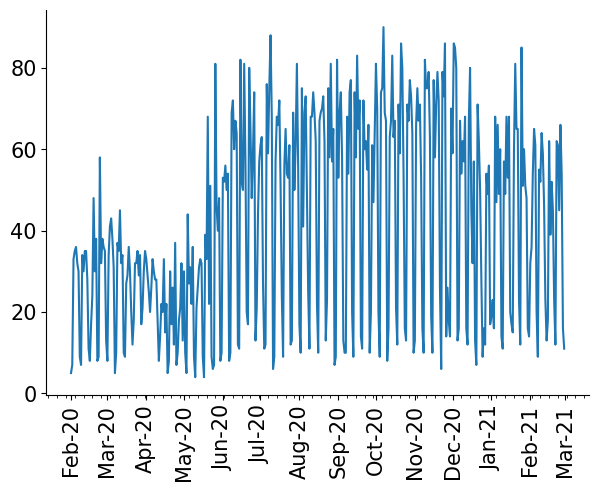

In [6]:
from jax import jit, vmap

dates_simulation = pd.date_range(start="2020-02-01", end="2021-02-28", freq="D")

parameters          = {}
parameters["gamma"] = 5/100
parameters["beta"]  = 0.02
parameters["ro"]    = 6/100
parameters["alpha"] = 1/120
parameters["Nw"]    = len(ward2id)
parameters["Np"]    = movement_df.mrn_id.unique().shape[0]

colonized    = []

key   = random.PRNGKey(0)
model = lambda pstatus, movement: amr_abm(pstatus, movement, ward2size, parameters)

from tqdm import tqdm
import numpy as onp

agents_state = onp.zeros(parameters["Np"])

for date in tqdm(dates_simulation):
    movement     = movement_df[movement_df["date"]==date]
    agents_state = model(agents_state, movement)
    colonized.append(np.sum(agents_state==Patient.colonized))

from utils.plot_utils import *

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(dates_simulation, colonized)
format_axis(ax)


In [7]:
from jax import random

def amr_abm(agents_state, movement, ward2size, parameters):
    """ Agent based model tracking colonized and susceptible patients with pre-defined movement patterns.

    Args:
        agents_state : agent state. {0: Patient.susceptible, 1: Patient.colonized}  Size: (n_patients)
        movement     : pd.Dataframe with patient locations and culture information.
        parameters   : dictionary of parameters, contains importation rate (gamma), nosocomial transmission rate (beta),
                        effective sensitivity (ro), and decolonization rate (alpha)
    """
    _, m = agents_state.shape

    γ   = parameters["gamma"] # importation rate.
    β   = parameters["beta"]  # nosocomial transmission rate.
    ρ   = parameters["ro"]    # effective sensitivity.
    α   = parameters["alpha"] # decolonization rate
    Nw  = parameters["Nw"]    # number of wards
    Np  = parameters["Np"]    # number of patients

    # Decolonize patients according to. P(C2S) = α
    #agents_state.at[:].set(np.maximum(agents_state - agents_state * (random.uniform(key=key, shape=(Np, )) < α), 0))
    #agents_state = agents_state - agents_state * (onp.random.uniform(size=(Np, )) < α)
    p_update = agents_state.copy()
    p_update = Patient.susceptible * (agents_state * onp.random.random(size=(Np, m)) <= α)

    # import patients.
    new_patients = movement[movement["first_day"]==1]["mrn_id"].values
    if new_patients.shape[0] > 0:
        # P(S2C) = \gamma - Probability of colonization given importation.
        #agents_state[new_patients] = Patient.colonized * (random.uniform(key=key, shape=(new_patients.shape[0], )) < γ)
        p_update[new_patients, :] = Patient.colonized * (onp.random.random(size=(new_patients.shape[0], m)) <= γ)

    # Compute force of infection for each ward.
    for i, ward_id in enumerate(movement["ward_id"].unique()):
        patients_ward = movement[movement["ward_id"]==ward_id]["mrn_id"].values

        # λ_i = β  * C / N  - Force of infection for ward i.
        λ_i = β * onp.sum(p_update[patients_ward,:]==Patient.colonized, axis=0) / ward2size[ward_id]

        # P(C2S)_i = λ_i, we add the state but if already colonized the state would be 2 (colonized via both importation and admissions) so we clip it to 1.
        #agents_state[patients_ward] = Patient.colonized * np.minimum(agents_state[patients_ward] + random.uniform(key=key, shape=(patients_ward.shape[0], )) < λ_i, 1)
        p_update[patients_ward, :] = p_update[patients_ward, :] + Patient.colonized * (onp.random.random(size=(patients_ward.shape[0], m)) <= λ_i)

    p_update = onp.clip(p_update, 0, 1)
    return p_update

def observe_ward(patients_state, movement, parameters):
    _, m = patients_state.shape
    ρ    = parameters["ro"] # effective sensitivity.
    Nw   = parameters["Nw"] # number of wards

    ward_colonized = onp.zeros((Nw, m))
    ward_positive  = onp.zeros((Nw, m))

    p_test = Observed.yes * (onp.random.random(size=(patients_state.shape[0], m)) <= patients_state * ρ)

    for i, ward_id in enumerate(movement["ward_id"].unique()):

        patients_ward      = movement.query(f"ward_id=={ward_id}")["mrn_id"].values
        patients_test_ward = movement.query(f"ward_id=={ward_id} and test==True")["mrn_id"].values

        ward_colonized[ward_id, :] = onp.sum(patients_state[patients_ward, :] == Patient.colonized, axis=0)
        ward_positive[ward_id,  :] = onp.sum(p_test[patients_test_ward, :]    == Observed.yes, axis=0)

    return ward_colonized, ward_positive

In [8]:
parameters          = {}
parameters["gamma"] = 5/100
parameters["beta"]  = 0.02
parameters["ro"]    = 6/100
parameters["alpha"] = 1/120
parameters["Nw"]    = len(ward2id)
parameters["Np"]    = movement_df.mrn_id.unique().shape[0]

# Function to be used for the ikeafk function.
# f_if  = lambda t, x, θ: f(t, x, θ[0, :], θ[1, :], N)
# g_if  = lambda t, x, θ: g(t, x, θ[2, :])
# f0_if = lambda θ: f0(pop=N, inf_init=10/100, m=model_settings["m"])

m               = 300
agents_state    = onp.zeros((movement_df.mrn_id.unique().shape[0], m))
ward_colonized  = np.full((len(dates_simulation), parameters["Nw"], m), np.nan)
ward_positive   = np.full((len(dates_simulation), parameters["Nw"], m), np.nan)

for i, date in enumerate(dates_simulation):
    movement                                   = movement_df[movement_df["date"]==date]
    agents_state                               = amr_abm(agents_state, movement, ward2size, parameters)
    ward_colonized[i, : ], ward_positive[i, :] = observe_ward(agents_state, movement, parameters)


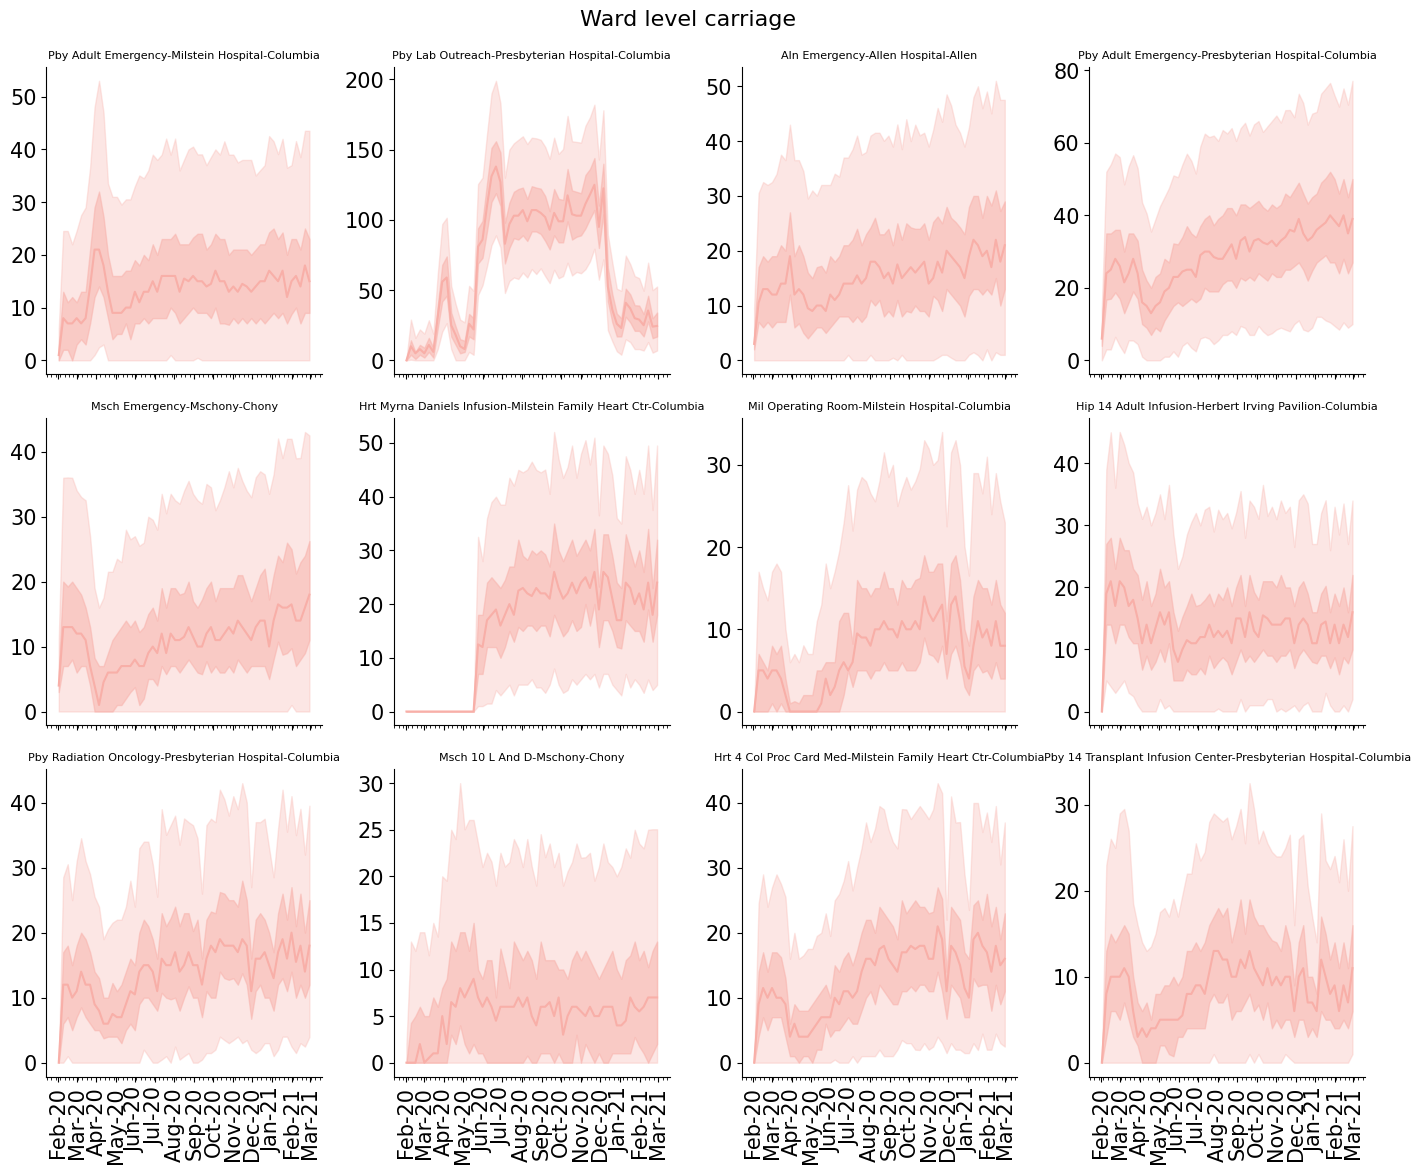

In [10]:
from utils.infer_utils import create_df_response

big_wards = [8, 13, 1, 0, 20, 4, 22, 11, 27, 23, 10, 12]

fig, axes = plt.subplots(3, 4, figsize=(14, 12), sharex=True)
for iax, ax in enumerate(axes.flatten()):

    c_df    = create_df_response(ward_colonized[:, big_wards[iax], :].T, time=len(dates_simulation), dates=dates_simulation)
    wk_c_df = c_df.drop(columns=["type"]).resample("W-Sun").sum()

    ax.plot(wk_c_df.index.values, wk_c_df["median"], color="#F8AFA8")
    ax.fill_between(wk_c_df.index.values, wk_c_df["low_95"], wk_c_df["high_95"], alpha=0.3, color="#F8AFA8")
    ax.fill_between(wk_c_df.index.values, wk_c_df["low_50"], wk_c_df["high_50"], alpha=0.5, color="#F8AFA8")

    ax.set_title(movement_df.query(f"ward_id=={big_wards[iax]}")["ward_total"].values[0], fontsize=8)
    format_axis(ax)

fig.suptitle("Ward level carriage", fontsize=16)
plt.tight_layout()


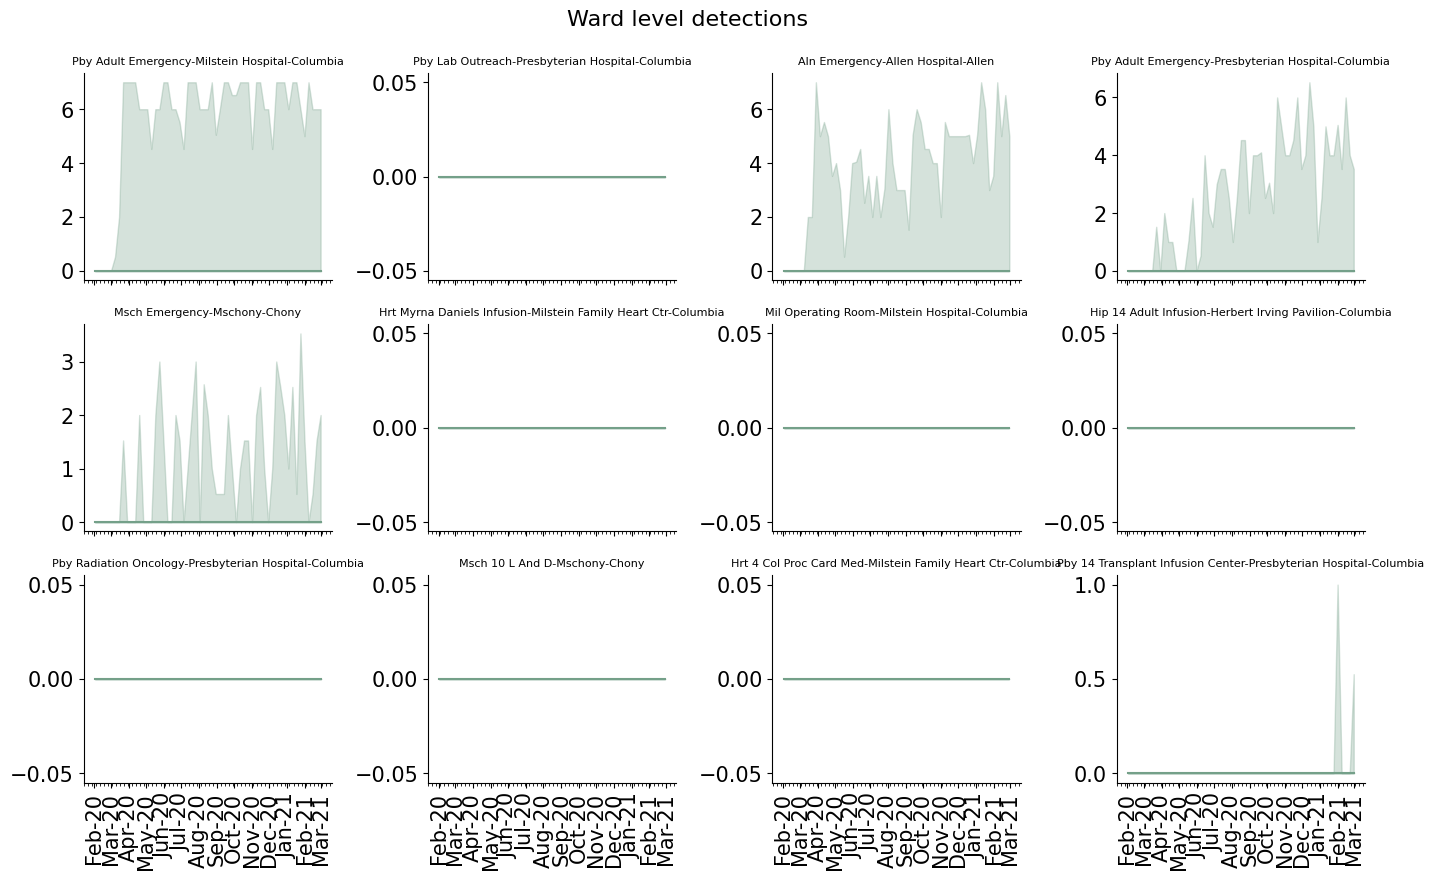

In [11]:
fig, axes = plt.subplots(3, 4, figsize=(14, 9), sharex=True)
for iax, ax in enumerate(axes.flatten()):

    c_df    = create_df_response(ward_positive[:, big_wards[iax], :].T, time=len(dates_simulation), dates=dates_simulation)
    wk_c_df = c_df.drop(columns=["type"]).resample("W-Sun").sum()

    ax.plot(wk_c_df.index.values, wk_c_df["median"], color="#74A089")
    ax.fill_between(wk_c_df.index.values, wk_c_df["low_95"], wk_c_df["high_95"], alpha=0.3, color="#74A089")
    ax.fill_between(wk_c_df.index.values, wk_c_df["low_50"], wk_c_df["high_50"], alpha=0.5, color="#74A089")

    ax.set_title(movement_df.query(f"ward_id=={big_wards[iax]}")["ward_total"].values[0], fontsize=8)
    format_axis(ax)

fig.suptitle("Ward level detections", fontsize=16)
plt.tight_layout()


In [12]:
from tqdm import tqdm

# TRANSFER MATRIX BETWEEN WARDS (ADJACENCY MATRIX)
movement_between_places = movement_df.copy().reset_index() # Movement between pair of wards
Nw                      = movement_between_places.ward_id.unique().shape[0]
mrns                    = movement_df.mrn_id.unique()

wrong_df                = []
adjacency_mat           = onp.full((Nw, Nw), 0)

for date in tqdm(dates_simulation):
    today_df    = movement_between_places[movement_between_places["date"]==pd.to_datetime(date)][["mrn_id", "ward_id"]].rename(columns={"ward_id": "ward_from"})
    tomorrow_df = movement_between_places[movement_between_places["date"]==pd.to_datetime(date) + pd.Timedelta(days=1)][["mrn_id", "ward_id"]].rename(columns={"ward_id": "ward_to"})
    trans_df    = pd.merge(today_df, tomorrow_df, on="mrn_id", how="inner")
    adjacency_mat[trans_df.ward_from.values, trans_df.ward_to.values] += 1

adjacency_df = pd.DataFrame(adjacency_mat, columns=movement_between_places.ward_id.unique(), index=movement_between_places.ward_id.unique())


100%|██████████| 394/394 [00:05<00:00, 70.83it/s]


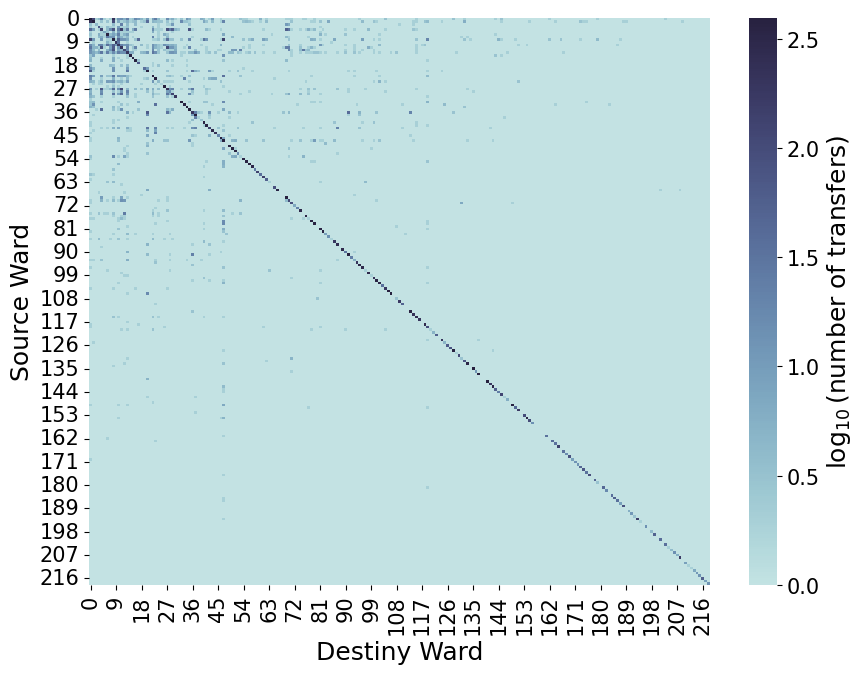

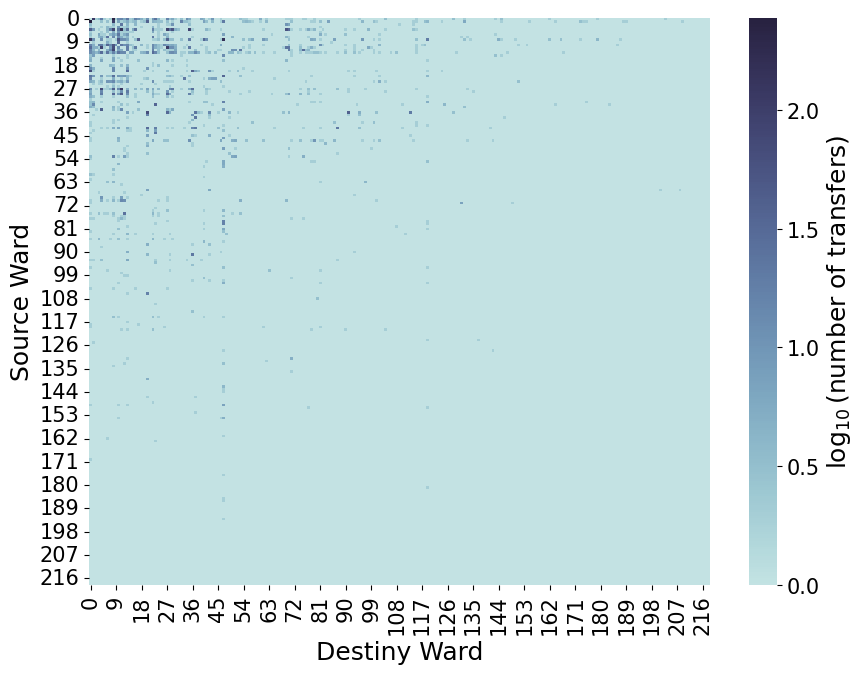

In [13]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(9, 7))
g = sns.heatmap(np.log10(adjacency_df+1), ax=ax, cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True), cbar_kws={'label': r"$\log_{{10}}$(number of transfers)"})
ax.set_xlabel("Destiny Ward")
ax.set_ylabel("Source Ward")
plt.tight_layout()


adjacency_non_diag = adjacency_mat.copy(); adjacency_non_diag[np.diag_indices_from(adjacency_non_diag)] = 0
adjacency2_df       = pd.DataFrame(adjacency_non_diag, columns=movement_between_places.ward_id.unique(), index=movement_between_places.ward_id.unique())
adjacency2_df

fig, ax = plt.subplots(1, 1, figsize=(9, 7))
g = sns.heatmap(np.log10(adjacency2_df+1), ax=ax, cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True), cbar_kws={'label': r"$\log_{{10}}$(number of transfers)"})
ax.set_xlabel("Destiny Ward")
ax.set_ylabel("Source Ward")
plt.tight_layout()

#x_tick_labels=['0','','','','','',r'$\vdots$','','','','','','112','','','','','',r'$\vdots$','','','','','','224']
#g.set(yticklabels=x_tick_labels)
#g.set(xticklabels=x_tick_labels)

## Cluster wards according to the number of transfers using infomap

<AxesSubplot: xlabel='Cluster', ylabel='Number of wards'>

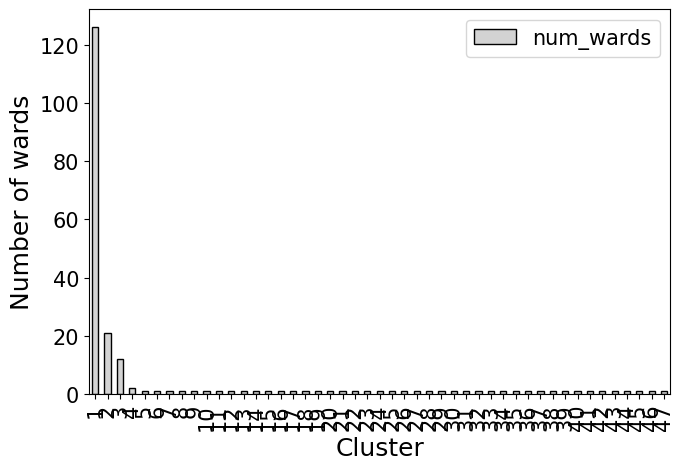

In [90]:
links_df1 = adjacency_df.reset_index().melt(id_vars=["index"], value_vars=list(range(Nw)))
links_df2 = adjacency2_df.reset_index().melt(id_vars=["index"], value_vars=list(range(Nw)))

links_df1.rename(columns={"index": "source", "variable": "target", "value": "weight"}, inplace=True)
links_df2.rename(columns={"index": "source", "variable": "target", "value": "weight"}, inplace=True)

links_df1 = links_df1[links_df1["weight"]>0]
links_df2 = links_df2[links_df2["weight"]>0]

id2ward = dict((v, k) for k, v in ward2id.items())

# save links and weights to csv with and without diagonal (transfer to same ward in a consecutive day)
links_df1.to_csv("links_diag.csv", index=False, sep=" ")
links_df2.to_csv("links_nondiag.csv", index=False, sep=" ")


cluster_diag_df              = pd.read_csv("infomap_diag.csv", sep=" ").rename(columns={"node_id": "ward_id"})
cluster_diag_df["ward_name"] = cluster_diag_df["ward_id"].map(id2ward)
cluster_diag_df["cluster"]   = cluster_diag_df.apply(lambda x: int(str(x.path).split(":")[0]), axis=1)
cluster_diag_df              = cluster_diag_df[["cluster", "ward_id", "ward_name"]].sort_values(by="cluster")
cluster_diag_df['num_wards'] = cluster_diag_df["cluster"].apply(lambda x: onp.sum(cluster_diag_df["cluster"] == x))


cluster_diag_df[["cluster", "num_wards"]].drop_duplicates(keep="first").plot(kind     = "bar",
                                                                            x         = "cluster",
                                                                            y         = "num_wards",
                                                                            facecolor = "lightgray",
                                                                            edgecolor = "black",
                                                                            figsize=(7.5, 5),
                                                                            xlabel="Cluster", ylabel="Number of wards")


## The idea here is then to put all the clusters of size 1 in other cluster and just keep the clusters of size > 1 apart.

/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_60311/4030235930.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_diag_df["cluster"][cluster_diag_df.cluster>=5] = 5


,cluster,ward_id,ward_name,num_wards
0,0,8,Pby Adult Emergency-Milstein Hospital-Columbia,126
92,0,173,Aln 2 Field East-Allen Hospital-Allen,126
91,0,143,Aln Same Day Surg-Allen Hospital-Allen,126
90,0,174,Mil 3 Oricu Surge-Milstein Hospital-Columbia,126
89,0,176,Msch 11 Central-Milstein Hospital-Columbia,126
...,...,...,...,...
199,4,192,Msch Emergency-Allen Hospital-Allen,43
200,4,194,Msch Emergency-Harkness Pavilion-Columbia,43
201,4,204,Mil Cystoscopy-Harkness Pavilion-Columbia,43
202,4,211,Pby Adult Emergency-Eye Institute-Columbia,43


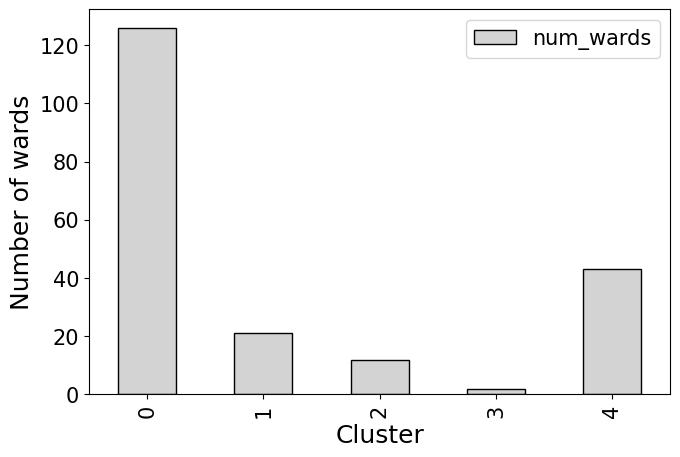

In [98]:
cluster_diag_df["cluster"][cluster_diag_df.cluster>=5] = 5
cluster_diag_df["cluster"] = cluster_diag_df["cluster"].map(lambda x: int(x-1))


cluster_diag_df['num_wards']                           = cluster_diag_df["cluster"].apply(lambda x: onp.sum(cluster_diag_df["cluster"] == x))

cluster_diag_df[["cluster", "num_wards"]].drop_duplicates(keep="first").plot(kind     = "bar",
                                                                            x         = "cluster",
                                                                            y         = "num_wards",
                                                                            facecolor = "lightgray",
                                                                            edgecolor = "black",
                                                                            figsize=(7.5, 5),
                                                                            xlabel="Cluster", ylabel="Number of wards")

cluster_diag_df

In [99]:

def observe_cluster(patients_state, movement, parameters):
    _, m           = patients_state.shape

    ρ              = parameters["ro"] # effective sensitivity.
    Nc             = parameters["Nc"] # number of clusters

    cluster_colonized = onp.zeros((Nc, m))
    cluster_positive  = onp.zeros((Nc, m))

    p_test            = Observed.yes * (onp.random.random(size=(patients_state.shape[0], m)) <= patients_state * ρ)

    for i, cluster in enumerate(movement["cluster"].unique()):

        patients_ward      = movement.query(f"cluster=={cluster}")["mrn_id"].values
        patients_test_ward = movement.query(f"cluster=={cluster} and test==True")["mrn_id"].values

        cluster_colonized[cluster, :] = onp.sum(patients_state[patients_ward, :] == Patient.colonized, axis=0)
        cluster_positive[cluster,  :] = onp.sum(p_test[patients_test_ward, :]    == Observed.yes, axis=0)

    return cluster_colonized, cluster_positive


In [116]:
wardid2cluster         = dict(zip(cluster_diag_df["ward_id"], cluster_diag_df["cluster"]))
movement_df["cluster"] = movement_df["ward_id"].map( wardid2cluster )
movement_df["cluster"] = movement_df["cluster"].fillna(cluster_diag_df.cluster.max())
movement_df["cluster"] = movement_df["cluster"].map(lambda x: int(x))
movement_df

,specimen_group,procedure_description,first_day,type_facility,mrn,building,specimen,date,encounter_id,place,ward,type_discharge,organism_name,test,ward_total,mrn_id,ward_id,cluster
0,NaN,NaN,1,Emergency,1000146281,Presbyterian Hospital,NaN,2020-02-01,115643352,Columbia,Pby Adult Emergency,Home or Self Care,NaN,0,Pby Adult Emergency-Presbyterian Hospital-Colu...,0,0,0
1,NaN,NaN,1,Emergency,1000474103,Presbyterian Hospital,NaN,2020-02-01,115633158,Columbia,Pby Adult Emergency,Home-Health Care Svc,NaN,0,Pby Adult Emergency-Presbyterian Hospital-Colu...,1,0,0
2,NaN,NaN,0,Emergency,1000474103,Presbyterian Hospital,NaN,2020-02-02,115633158,Columbia,Pby Adult Emergency,Home-Health Care Svc,NaN,0,Pby Adult Emergency-Presbyterian Hospital-Colu...,1,0,0
3,NaN,NaN,1,Emergency,1000474103,Presbyterian Hospital,NaN,2020-11-12,130221849,Columbia,Pby Adult Emergency,Home or Self Care,NaN,0,Pby Adult Emergency-Presbyterian Hospital-Colu...,1,0,0
4,NaN,NaN,1,Emergency,1000711708,Allen Hospital,NaN,2020-02-01,115633072,Allen,Aln Emergency,Home or Self Care,NaN,0,Aln Emergency-Allen Hospital-Allen,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728527,Blood,BLOOD CULTURE,1,Emergency,1400222644,Allen Hospital,"Blood, Peripheral",2021-02-28,137159716,Allen,Aln Emergency,Interim / Custodial Care Facility,ENTEROCOCCUS FAECALIS,1,Aln Emergency-Allen Hospital-Allen,103505,1,0
728532,NaN,NaN,1,Emergency,1400222652,Presbyterian Hospital,NaN,2021-02-28,137160006,Columbia,Pby Adult Emergency,Home or Self Care,NaN,0,Pby Adult Emergency-Presbyterian Hospital-Colu...,103506,0,0
728534,NaN,NaN,1,Emergency,1400222664,Presbyterian Hospital,NaN,2021-02-28,137160685,Columbia,Pby Adult Emergency,Home or Self Care,NaN,0,Pby Adult Emergency-Presbyterian Hospital-Colu...,103507,0,0
728536,NaN,NaN,1,Emergency,1400222672,Allen Hospital,NaN,2021-02-28,137160951,Allen,Aln Emergency,Home or Self Care,NaN,0,Aln Emergency-Allen Hospital-Allen,103508,1,0


In [119]:

parameters          = {}
parameters["gamma"] = 5/100
parameters["beta"]  = 0.02
parameters["ro"]    = 6/100
parameters["alpha"] = 1/120
parameters["Nw"]    = len(ward2id)
parameters["Nc"]    = cluster_diag_df.cluster.unique().shape[0]
parameters["Np"]    = movement_df.mrn_id.unique().shape[0]

# Function to be used for the ikeafk function.
# f_if  = lambda t, x, θ: f(t, x, θ[0, :], θ[1, :], N)
# g_if  = lambda t, x, θ: g(t, x, θ[2, :])
# f0_if = lambda θ: f0(pop=N, inf_init=10/100, m=model_settings["m"])

m               = 300
agents_state    = onp.zeros((movement_df.mrn_id.unique().shape[0], m))
cluster_colonized  = np.full((len(dates_simulation), parameters["Nc"], m), np.nan)
cluster_positive   = np.full((len(dates_simulation), parameters["Nc"], m), np.nan)

for i, date in enumerate(dates_simulation):
    movement                                   = movement_df[movement_df["date"]==date]
    agents_state                               = amr_abm(agents_state, movement, ward2size, parameters)
    cluster_colonized[i, : ], cluster_positive[i, :] = observe_cluster(agents_state, movement, parameters)


In [ ]:
from utils.infer_utils import create_df_response

clusters = [0, 1, 2, 3, 4]

fig, axes = plt.subplots(2, 3, figsize=(14, 12), sharex=True)
for iax, ax in enumerate(axes.flatten()):

    c_df    = create_df_response(cluster_colonized[:, clusters[iax], :].T, time=len(dates_simulation), dates=dates_simulation)
    wk_c_df = c_df.drop(columns=["type"]).resample("W-Sun").sum()

    ax.plot(wk_c_df.index.values, wk_c_df["median"], color="#F8AFA8")
    ax.fill_between(wk_c_df.index.values, wk_c_df["low_95"], wk_c_df["high_95"], alpha=0.3, color="#F8AFA8")
    ax.fill_between(wk_c_df.index.values, wk_c_df["low_50"], wk_c_df["high_50"], alpha=0.5, color="#F8AFA8")

    ax.set_title(movement_df.query(f"cluster=={clusters[iax]}")["cluster"].values[0], fontsize=8)
    format_axis(ax)

fig.suptitle("Cluster level carriage", fontsize=16)
plt.tight_layout()


In [ ]:

fig, axes = plt.subplots(2, 3, figsize=(14, 12), sharex=True)
for iax, ax in enumerate(axes.flatten()):

    c_df    = create_df_response(ward_positive[:, clusters[iax], :].T, time=len(dates_simulation), dates=dates_simulation)
    wk_c_df = c_df.drop(columns=["type"]).resample("W-Sun").sum()

    ax.plot(wk_c_df.index.values, wk_c_df["median"], color="#74A089")
    ax.fill_between(wk_c_df.index.values, wk_c_df["low_95"], wk_c_df["high_95"], alpha=0.3, color="#74A089")
    ax.fill_between(wk_c_df.index.values, wk_c_df["low_50"], wk_c_df["high_50"], alpha=0.5, color="#74A089")

    ax.set_title(movement_df.query(f"cluster=={clusters[iax]}")["cluster"].values[0], fontsize=8)
    format_axis(ax)

fig.suptitle("Cluster level detections", fontsize=16)
plt.tight_layout()



In [ ]:
# DEFINITION OF CARRIGE, BURN-IN TIME THE FIRST 4 WEEKS, ALL BUILDINGS THAT ARE ONLY OUTPATIENTS. EMAIL JASON ZUCKER.
## TRY INFERENCE WITH DIFFERENT DATA MANIPULATION/PREPROCESSING.